# 1. Preparing

In [83]:
import os
import csv
import sys
import json
import time
import glob
import torch
import scipy.io
import PIL.Image
import collections
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms
import torchvision.datasets as datasets

from pathlib import Path
from torchvision import transforms
from abc import ABC, abstractmethod
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score

In [7]:
meta_file_path = '/mnt/data/sixiongshan/data/vggface2/identity_meta.csv'
root = '/mnt/data/sixiongshan/data/vggface2/train'
folder = 'n009177'

In [8]:
df = pd.read_csv(meta_file_path, sep=',\s+', encoding='utf-8', engine='python')
df.head()

,Class_ID,Name,Sample_Num,Flag,Gender
0,n000001,"""14th_Dalai_Lama""",424,0,m
1,n000002,"""A_Fine_Frenzy""",315,1,f
2,n000003,"""A._A._Gill""",205,1,m
3,n000004,"""A._J._Buckley""",387,1,m
4,n000005,"""A._J._Pierzynski""",229,1,m


# 2. Dataset

In [72]:
class VGGFace2Data(Dataset): 
    def __init__(self,
                 root: str='/mnt/data/sixiongshan/data/vggface2',
                 folder: str='n009177',
                 transform: bool=True,
                 train: bool=True):
        
        self.folder = folder
        self.train = train
        self.transform = transform
        
        if self.train:
            self.root = root + '/train'
        else:
            self.root = root + '/test'
        self.data_path = self.root + '/' + folder
        
        self.img_info = []
        
        # Save image information
        for i, file in enumerate(glob.glob(self.data_path + '/*.jpg')):
            file = file.strip()
            class_id = file.split('/')[- 2]  # e.g. n004332
            self.img_info.append({'class_id': class_id,
                                  'source': file})
        
        # Transformers
        RGB_MEAN, RGB_STD = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        self.train_transform = transforms.Compose([transforms.Resize(256), 
                                                   transforms.RandomCrop(224),
                                                   transforms.ToTensor(),
                                                   transforms.Normalize(mean=RGB_MEAN,
                                                                        std=RGB_STD)])

        self.test_transform = transforms.Compose([transforms.Resize(256), 
                                                  transforms.CenterCrop(224),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean=RGB_MEAN,
                                                                       std=RGB_STD)])

    def __getitem__(self, index):
        info = self.img_info[index]
        source = info['source']
        class_id = info['class_id']
        img = PIL.Image.open(os.path.join(self.root, source))
        
        if not self.transform:
            return index, img, class_id
        
        if self.train:
            img = self.train_transform(img)
        else:
            img = self.test_transform(img)
        return index, img, class_id

    def __len__(self):
        return len(self.img_info)

## 2.1. Try out the Dataset

In [73]:
test = VGGFace2Data()
test_raw = VGGFace2Data(transform=False)

### 2.1.1. Raw Data

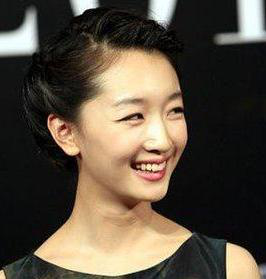

In [74]:
test_raw[176][1]

### 2.1.2 Transformed Data

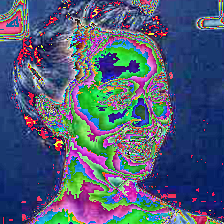

In [75]:
transforms.ToPILImage()(test[176][1]).convert('RGB')

In [76]:
test[176][1]

tensor([[[ 0.9474,  0.4337, -0.0116,  ...,  0.0398, -0.5596, -1.2445],
         [ 0.9646,  0.5536,  0.0398,  ..., -0.0629, -0.6281, -1.2274],
         [ 0.9817,  0.5707,  0.0569,  ...,  0.0227, -0.5938, -1.1760],
         ...,
         [-0.4739,  1.0502,  1.6153,  ..., -1.9467, -1.9809, -1.9809],
         [-0.6794,  0.3823,  1.3584,  ..., -1.9980, -1.9980, -1.9980],
         [-1.3815, -1.1075, -0.3883,  ..., -2.0323, -1.9980, -1.9980]],

        [[ 1.2556,  0.7129,  0.2227,  ...,  0.3452, -0.3025, -1.0553],
         [ 1.2731,  0.8354,  0.2752,  ...,  0.2402, -0.3725, -0.9853],
         [ 1.2906,  0.8529,  0.2927,  ...,  0.3277, -0.3025, -0.9328],
         ...,
         [-0.4076,  1.0805,  1.5882,  ..., -1.8431, -1.8782, -1.8606],
         [-0.6001,  0.4153,  1.3606,  ..., -1.8957, -1.8782, -1.8782],
         [-1.3179, -1.0903, -0.4076,  ..., -1.9657, -1.8782, -1.8782]],

        [[ 1.4548,  0.9145,  0.4439,  ...,  0.6008, -0.0267, -0.7587],
         [ 1.4722,  1.0365,  0.4962,  ...,  0

# 3. DataLoader

## 3.1 Loader Class

In [77]:
class VGGFace2Loader:
    def __init__(self,
                 root: str='/mnt/data/sixiongshan/data/vggface2/train',
                 folder: str='n009177',
                 transform: bool=True):

        print('Hi! I am setting train_set for you.')
        self.train_set = VGGFace2DataF(root,
                                       folder,
                                       transform,
                                       True)
        print('\nHi! I am setting test_set for you.')
        self.train_set = VGGFace2DataF(root,
                                       folder,
                                       transform,
                                       False)
    def loaders(self,
                batch_size: int=1,
                shuffle_train: bool=True,
                shuffle_test: bool=False,
                num_workers: int = 0) -> (DataLoader, DataLoader):

        train_loader = DataLoader(dataset=self.train_set,
                                  batch_size=batch_size,
                                  shuffle=shuffle_train,
                                  num_workers=num_workers,
                                  drop_last=False)

        test_loader = DataLoader(dataset=self.test_set,
                                 batch_size=batch_size,
                                 shuffle=shuffle_test,
                                 num_workers=num_workers,
                                 drop_last=False)
        return train_loader, test_loader

    def __repr__(self):
        return self.__class__.__name__

## 3.2. Loading Function

In [78]:
def load_dataset(loader_name: str='vggface2',
                 root: str='/mnt/data/sixiongshan/data/vggface2/train',
                 folder: str='n009177',
                 transform: bool=True):
    
    if loader_name == 'vggface2':
        return VGGFace2Loader(root, folder, transform)

# 4. Network

## 4.1. Architecture

## 4.2. Build Network

# 5. Trainer

## 5.1. Base Model

In [81]:
class BaseTrainer(ABC):
    def __init__(self,
                 optimizer_name: str,
                 lr: float,
                 n_epochs: int,
                 lr_milestones: tuple,
                 batch_size: int,
                 weight_decay: float,
                 device: str,
                 n_jobs_dataloader: int):

        super().__init__()
        self.optimizer_name = optimizer_name
        self.lr = lr
        self.n_epochs = n_epochs
        self.lr_milestones = lr_milestones
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        self.device = device
        self.n_jobs_dataloader = n_jobs_dataloader

    @abstractmethod
    def train(self, dataset, net):
        pass

    @abstractmethod
    def test(self, dataset, net):
        pass

In [80]:
class BaseEvaluater(ABC):
    def __init__(self,
                 batch_size: int,
                 device: str,
                 n_jobs_dataloader: int):

        super().__init__()
        self.batch_size = batch_size
        self.device = device
        self.n_jobs_dataloader = n_jobs_dataloader


    @abstractmethod
    def test(self, dataset, net):
        pass

## 5.2. Reconstruction Trainer

In [84]:
class RecTrainer_(BaseTrainer):
    def __init__(self,
                 eta: float= 1,
                 optimizer_name: str = 'adam',
                 lr: float = 0.01,
                 n_epochs: int = 60,
                 lr_milestones: tuple = (50, 100, 150, 200),
                 batch_size: int = 32,
                 weight_decay: float = 1e-6,
                 device: str = 'cuda:1',
                 n_jobs_dataloader: int = 0):

        super().__init__(optimizer_name, lr, n_epochs, lr_milestones, batch_size,
                         weight_decay, device, n_jobs_dataloader)
        self.eta = eta
        self.train_time = None
        self.test_auc = None
        self.test_time = None
        self.test_scores = None

    def train(self, dataset, net):
        train_loader, _ = dataset.loaders(batch_size=self.batch_size,
                                          num_workers=self.n_jobs_dataloader)

        print('Hey I am loading net for you!')
        net = net.to(self.device)

        print('Setting hyper-parameters!')
        criterion = nn.MSELoss(reduction='none')
        optimizer = optim.Adam(net.parameters(),
                               lr=self.lr,
                               weight_decay=self.weight_decay)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                                   milestones=self.lr_milestones,
                                                   gamma=0.1)

        print('Starting training...')
        start_time = time.time()
        net.train()
        for epoch in range(self.n_epochs):
            if epoch in self.lr_milestones:
                print('  LR scheduler: new learning rate is %g' %
                            float(scheduler.get_lr()[0]))

            epoch_loss, n_batches = 0.0, 0
            epoch_start_time = time.time()

            for data in train_loader:
                X, y, _ = data
                X, y = X.to(self.device), y.to(self.device)
                optimizer.zero_grad()
                X_pred = net(X)
                dist = criterion(X_pred, X)
                dist_mean = torch.mean(dist, axis=[1, 2])
                # The following is the core loss function
                loss = torch.mean(dist_mean)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                n_batches += 1

            scheduler.step()
            epoch_train_time = time.time() - epoch_start_time
            print(f'| Epoch: {epoch + 1:03}/{self.n_epochs:03} | '
                        f'Train Time: {epoch_train_time:.3f}s '
                        f'| Train Loss: {epoch_loss / n_batches:.6f} |')

        self.train_time = time.time() - start_time
        print('Training Time: {:.3f}s'.format(self.train_time))
        print('Finished training.')
        return net

    def test(self, dataset, net):
        _, test_loader = dataset.loaders(batch_size=self.batch_size,
                                         num_workers=self.n_jobs_dataloader)
        net = net.to(self.device)
        criterion = nn.MSELoss(reduction='none')

        print('Starting testing...')
        epoch_loss = 0.0
        n_batches = 0
        start_time = time.time()
        idx_label_score = []
        net.eval()
        with torch.no_grad():
            for data in test_loader:
                X, y, idx = data
                X, y, idx = X.to(self.device), y.to(self.device), idx.to(self.device)

                X_pred = net(X)
                dist = criterion(X_pred, X)

                dist_mean = torch.mean(dist, axis=[1, 2])
                scores = dist_mean
                loss = torch.mean(dist_mean)

                # Save triples of (idx, label, score) in a list
                idx_label_score += list(zip(idx.cpu().data.numpy().tolist(),
                                            y.cpu().data.numpy().tolist(),
                                            scores.cpu().data.numpy().tolist()))

                # epoch_loss += loss.item()
                n_batches += 1

        self.test_time = time.time() - start_time
        self.test_scores = idx_label_score

        # Compute AUC
        _, labels, scores = zip(*idx_label_score)
        labels = np.array(labels)
        scores = np.array(scores)
        # self.test_auc = roc_auc_score(labels, scores)

        # Log results
        # print('Test Loss: {:.6f}'.format(epoch_loss / n_batches))
        # print('Test AUC: {:.2f}%'.format(100. * self.test_auc))
        print('Test Time: {:.3f}s'.format(self.test_time))
        print('Finished testing.')

## 5.3. Reconstruction Evaluater

In [85]:
class RecEvaluater(BaseEvaluater):
    def __init__(self,
                 eta: float = 1,
                 batch_size: int = 32,
                 device: str = 'cuda:1',
                 n_jobs_dataloader: int = 0):
        super().__init__(batch_size, device, n_jobs_dataloader)

        # Hyper-parameter for the weight of anomaly training
        self.eta = eta

        # Results
        self.test_auc = None
        self.test_time = None
        self.test_scores = None

    def test(self, optimizer_, dataset, net):
        # Get test data loader
        all_loader = dataset.loaders(batch_size=self.batch_size,
                                     num_workers=self.n_jobs_dataloader)

        # Set device for network
        net = net.to(self.device)

        # Set loss
        criterion = nn.MSELoss(reduction='none')

        # Testing
        print('Starting evaluating...')
        epoch_loss = 0.0
        n_batches = 0
        start_time = time.time()
        idx_label_score = []
        net.eval()
        with torch.no_grad():
            for data in all_loader:
                X, y, idx = data
                X, y, idx = X.to(self.device), y.to(self.device), idx.to(self.device)

                X_pred = net(X)
                dist = criterion(X_pred, X)
                if optimizer_ == 'rec':
                    losses = torch.where(y == 0,
                                         dist,
                                         self.eta * ((dist) ** (- 1)))
                else:
                    losses = dist
                loss = torch.mean(losses)
                scores = torch.mean(dist, axis=[1, 2])

                # Save triples of (idx, label, score) in a list
                idx_label_score += list(zip(idx.cpu().data.numpy().tolist(),
                                            y.cpu().data.numpy().tolist(),
                                            scores.cpu().data.numpy().tolist()))

                epoch_loss += loss.item()
                n_batches += 1

        self.test_time = time.time() - start_time
        self.test_scores = idx_label_score

        # Compute AUC
        _, labels, scores = zip(*idx_label_score)
        labels = np.array(labels)
        scores = np.array(scores)

        # Log results
        print('Test Loss: {:.6f}'.format(epoch_loss / n_batches))
        print('Test Time: {:.3f}s'.format(self.test_time))
        print('Finished testing.')

# 6. Model

## 6.1. Model for Training

In [86]:
class RecModel:
    def __init__(self,
                 optimizer_: str = 'rec',
                 eta: float = 1.0):
        known_optimizer_ = ('rec', 'rec_unsupervised')
        assert optimizer_ in known_optimizer_
        self.optimizer_ = optimizer_
        self.eta = eta
        self.net_name = None
        self.net = None
        self.trainer = None
        self.optimizer_name = None
        self.results = {'train_time': None, 'test_auc': None,
                        'test_time': None, 'test_scores': None}

    def set_network(self, net_name):
        self.net_name = net_name
        self.net = build_network(net_name)

    def train(self, dataset, eta: float = 1, optimizer_name: str = 'adam',
              lr: float = 0.001, n_epochs: int = 60, lr_milestones: tuple = (100, 160, 220),
              batch_size: int = 32, weight_decay: float = 1e-6, device: str = 'cuda:1',
              n_jobs_dataloader: int = 0):
        print('Learning rate: {}'.format(lr))
        self.optimizer_name = optimizer_name

        if self.optimizer_ == 'rec':
            self.trainer = RecTrainer(eta, optimizer_name, lr, n_epochs, lr_milestones,
                                      batch_size, weight_decay, device, n_jobs_dataloader)
        if self.optimizer_ == 'rec_unsupervised':
            self.trainer = RecTrainer_(eta, optimizer_name, lr, n_epochs, lr_milestones,
                                       batch_size, weight_decay, device, n_jobs_dataloader)

        self.net = self.trainer.train(dataset, self.net)
        self.results['train_time'] = self.trainer.train_time

    def test(self, dataset, device: str = 'cuda:1', n_jobs_dataloader: int = 0):
        self.trainer.test(dataset, self.net)
        if self.trainer.test_auc:
            self.results['test_auc'] = self.trainer.test_auc
        self.results['test_time'] = self.trainer.test_time
        self.results['test_scores'] = self.trainer.test_scores

    def save_model(self, export_model, save_ae=True):
        net_dict = self.net.state_dict()
        torch.save({'net_dict': net_dict}, export_model)

    def load_model(self, model_path, load_ae=False, map_location='cpu'):
        model_dict = torch.load(model_path, map_location=map_location)
        self.net.load_state_dict(model_dict['net_dict'])

    def save_results(self, export_json):
        with open(export_json, 'w') as fp:
            json.dump(self.results, fp)

## 6.2. Model for Evaluating

In [87]:
class RecModelEval:
    def __init__(self,
                 optimizer_,
                 eta: float = 1.0):
        known_optimizer_ = ('rec', 'rec_unsupervised')
        assert optimizer_ in known_optimizer_
        self.optimizer_ = optimizer_
        self.eta = eta
        self.net = None
        self.evaluater= None
        self.optimizer_name = None
        self.results = {'test_time': None,'test_scores': None}

    def set_network(self, net_name):
        self.net_name = net_name
        self.net = build_network(net_name)

    def load_model(self, model_path, map_location='cuda:1'):
        model_dict = torch.load(model_path, map_location=map_location)
        self.net.load_state_dict(model_dict['net_dict'])

    def test(self,
             dataset,
             eta: float = 1,
             batch_size: int = 32,
             device: str = 'cuda:1',
             n_jobs_dataloader: int = 0):

        if self.evaluater is None:
            self.evaluater = RecEvaluater(eta, batch_size, device, n_jobs_dataloader)

        self.evaluater.test(self.optimizer_, dataset, self.net)
        self.results['test_time'] = self.evaluater.test_time
        self.results['test_scores'] = self.evaluater.test_scores

    def save_results(self, export_json):
        with open(export_json, 'w') as fp:
            json.dump(self.results, fp)